# CS492 Assignment #1: [ Project Title ]

## Objective

Social Network Service such as Twitter needs contents moderation. This assignment is around that. Specifically, students need to perform the following :

* Understand there's a bias in the classification result
* Implement measures to compute the biasness
* Implement debiasing techniques on data side and post processing side
* Discuss isseus around the bias


 This notebook provides (1) how to build the classifier and (2) skeleton codes for implementing the measurement and debiasing techniques, so students need to fill in. (Ideally,) the result of student coding is automatically synchronized with the visualization: once you update your code for measuring the bias, the results are going to be presented in the visualization tab as well so that you can easily see the improvement. Note that this is for better visualization, not for grading. The objective of this assignment is not optimizing the biasness but do the implementation and discuss around it. More investigation on the code is highly encouraged.

# How to build a classifier?

In this assignment, we are going to build the classifier that classifies whether a tweet needs to be moderated. Especially, we are going to use supervised learning for building the classifier. To do that, we are going to follow the procedure below:

    1. Import dataset
    2. Preprocess the dataset    -- Debiasing technique is needed here
    3. Train the model (includes post-processing mechanism).    -- Debiasing technique is needed here
    4. Evaluate the model
    5. See the classification result with totally new tweets
        5-1. Import dataset
        5-2. Predict
        5-3. See the result
    
From now, we're going to go through each step deeply.

## 1. Import dataset

We first import the dataset. The original dataset is .csv, and we're going to load the data and do formatting. Here, formatting means that the label column name should be "class", and tweet column name should be "tweet"

In [7]:
# !conda install -c conda-forge textstat --yes

import process

datasetInfo = {
    'filename': 'david.csv',                      # the filename
    'code': 'david',
    'label': ['Hate', 'Offensive', 'Neither']     # Labels
}

data = process.dataImporting(datasetInfo['filename'])
formattedData = process.dataFormatting(data, datasetInfo['code'])
    
formattedData

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


## 2. Preprocess the dataset

We are going to preprocess the data. We are going to vectorize each tweet and use TF-IDF to generate a matrix.

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

result = process.dataPreprocessing(formattedData)

result['M']


Feature generation ...


/opt/anaconda3/envs/tweetBias/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(24783, 11172)
TfidfVectorizer(decode_error='replace', max_df=0.75, max_features=10000,
                min_df=5, ngram_range=(1, 3), norm=None,
                preprocessor=<function dataPreprocessing.<locals>.preprocess at 0x7fca5545a0d0>,
                smooth_idf=False,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function dataPreprocessing.<locals>.tokenize at 0x7fca5545a1e0>)
['ab', 'abil', 'abl', 'abo', 'abort', 'abov', 'absolut', 'abt', 'abu', 'abus', 'accent', 'accept', 'accid', 'accident', 'accord', 'account', 'accur', 'acknowledg', 'across', 'act', 'act like', 'act like b

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 2., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 3. Train the model

Now we're going to train the model.

In [11]:
result2 = process.buildModel(result)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s finished


## 4. Evaluate the model

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       164
           1       0.96      0.91      0.94      1905
           2       0.83      0.94      0.88       410

    accuracy                           0.89      2479
   macro avg       0.75      0.81      0.77      2479
weighted avg       0.91      0.89      0.90      2479



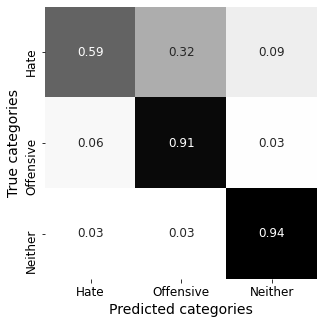

In [14]:
result3 = process.evaluateModel(result2, datasetInfo['label'])

## 5. See the classification result and see there's bias

Now we're going to use the model to classify a totally new tweet dataset. To do that, we are going to import another dataset, predict, and see the result

## 5-1. Import dataset

In [16]:
import pandas as pd

filepath='./blackTweets_0.5.txt'
tweetList = []

cnt = 0

with open(filepath) as fp:
    for line in fp :
        tweetList.append(line.strip())
        cnt = cnt + 1
        
        line = fp.readline()

blackTweet = pd.DataFrame(data={'tweet': tweetList, 'class': [0 for i in range(len(tweetList))]})

filepath='./whiteTweets_0.5.txt'
tweetList = []

cnt = 0

with open(filepath) as fp:
    for line in fp :
        tweetList.append(line.strip())
        cnt = cnt + 1
        
        line = fp.readline()

whiteTweet = pd.DataFrame(data={'tweet': tweetList, 'class': [1 for i in range(len(tweetList))]})